## LSTM - Sine Wave Prediction

Here, we'll use LSTM to predict the sine wave, considering it as the time-series.

$y = sin(x)$

**Step 1 : Importing the Libraries**

In [379]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [380]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

**Step 2 : Loading or Formulating the dataset**

Since this is a **sine** series, we'll create the dataset using continious $x$ value from $0-100$ with $0.1$ interval.

In [381]:
x = np.linspace(0,799,800)
y = np.sin(x*2*3.1416/40)

Converting it into Tensor for further processing

In [382]:
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)

Let's now plot the **sine** series.

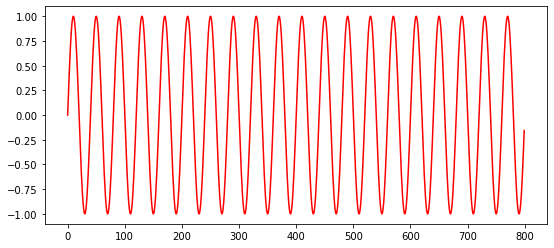

In [383]:
plt.figure(figsize=(9,4))
plt.plot(x.cpu(),y.cpu(), c='red')

**Step 3 : Train-Test Split**

Since we have $500$ data points, let's take $400$ for training and $100$ for testing.

In [384]:
test_size = 40
x_train = y[:-test_size]
x_test = y[-test_size:]

**Step 4 : Data Processing**

This method is to create the data dimension for the LSTM. So, LSTM needs data in the format like this for example.

Say we have the following series:

$x_t, x_{t+1}, x_{t+2}, x_{t+3}, ... , x_{t_n}$

LSTM require us to provide to it, number of data points by looking at which it will predict the next value. Meaning, *if we want LSTM to use previous 2 values to predict the next one value - > **windowsize*** we would need to provide to it :

$X = [x_t, x_{t+1}]$

$Y = [x_{t+2}]$

This function do just that, it takes the $x$ sequence and the *windowsize* as input and return the sequence accordingly.


In [385]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

Passing the sequence to create the sequence LSTM requires. Let's say we need the *windowsize* as 12. That is, we want LSTM to look at the previous 12 enteries to predict the next vlaue.

In [386]:
window_size = 40
x_y_train_seq  = create_inout_sequences(x_train, window_size)

Printing the first value would result in a touple with 12 dimensional tensor and a one dimensional tensor

In [387]:
x_y_train_seq[30]

(tensor([-1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,
          1.4693e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
          7.0712e-01,  8.0903e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5105e-01,  8.9100e-01,  8.0901e-01,
          7.0709e-01,  5.8777e-01,  4.5397e-01,  3.0900e-01,  1.5641e-01,
         -2.2039e-05, -1.5646e-01, -3.0904e-01, -4.5401e-01, -5.8780e-01,
         -7.0712e-01, -8.0903e-01, -8.9102e-01, -9.5106e-01, -9.8769e-01],
        device='cuda:0'),
 tensor([-1.], device='cuda:0'))

**Step 5 : Modelling**

Here we have a single dimension timeseries with only one feature.

$x_t, x_{t+1}, x_{t+2}, x_{t+3}, ... , x_{t_n}$

So,

**input_layer_size : 1**

Also we only need one value in the output so,

**output_layer_size = 1**

The value of **hidden_layer_size** is arbitrary and experimental, for this example let's set it to 100.


In [388]:
class LSTMModule(nn.Module):

    def __init__(self):
        super(LSTMModule, self).__init__()

        self.input_layer_size = 1
        self.hidden_layer_size = 50
        self.output_layer_size = 1

        self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size)
        self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.fc(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Defining Loss function and Optimizer for the model training. 

***Loss Function** -> MSE Loss*<br/>
***Optimizer** -> Stocastic Gradient Decent (SGD)*

In [389]:
model = LSTMModule().to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  

In [390]:
print(model)

LSTMModule(
  (lstm): LSTM(1, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


**Step 6 : Model Training**

In [391]:
epochs = 10

loss = 0

losses = []

model.train()

for i in range(epochs):

    for seq, labels in x_y_train_seq:

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, 50).to(device), torch.zeros(1, 1, 50).to(device))

        y_pred = model(seq)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        loss = single_loss.item()

    losses.append(loss)
    
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {loss:10.8f}')

print(f'epoch: {i:3} loss: {loss:10.10f}')

epoch:   1 loss: 0.05268842
epoch:   3 loss: 0.00421595
epoch:   5 loss: 0.00010947
epoch:   7 loss: 0.00007855
epoch:   9 loss: 0.00007277
epoch:   9 loss: 0.0000727656


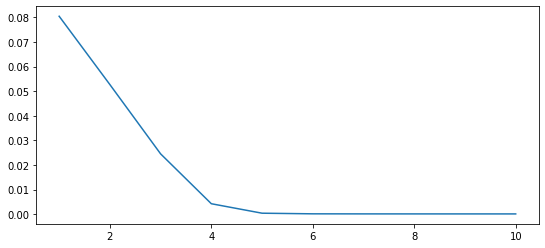

In [392]:
plt.figure(figsize=(9,4))
plt.plot(np.linspace(1,len(losses),len(losses), dtype=int),losses)

**Step 7 : Prediction for Testing**

**NOTE : ** We should always use the window size timestep to predict for the number of time step in the future. For eg. If our window size is 40 timestep, then we should predict upto 40 timestep in the future only. If we increase the number of timestep for prediction, the confidency may deteriorate.

In [393]:
model.eval()

future_timesteps = 40

x_test = x_test.cpu().tolist()

for i in range(future_timesteps):
    seq = torch.FloatTensor(x_test[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, 50).to(device),
                        torch.zeros(1, 1, 50).to(device))
        x_test.append(model(seq).item())

If you print the length of the x_test list, you will see it contains 80 items. The last 40 predicted items can be recovered as follows:

In [394]:
preds = x_test[40:]

Once we get the prediction for testing, let's plot the predictions.

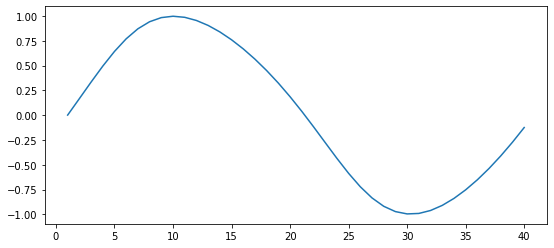

In [395]:
x_test_value = np.linspace(1,len(preds),len(preds), dtype=int)

plt.figure(figsize=(9,4))
plt.plot(x_test_value,preds)

Let's now plot the entire series.

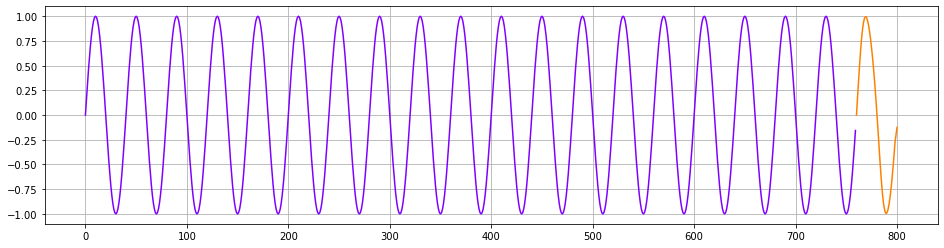

In [396]:

x_value = np.linspace(1,len(y),len(y), dtype=int)
plt.figure(figsize=(16,4))
plt.grid(True)
plt.plot(x_train.cpu().tolist(), color="#8000ff")
plt.plot(np.linspace(len(x_train),len(y),len(preds), dtype=int), preds, color="#ff8000")